# Project Description

The dataset contains information on credit card holders. The objective is to estimate the probability of
default. We can download the dataset here: https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset

# Overview of the Solution

The solution will cover the following four steps:
* Discover and Visualize the Data to Gain Insights
* Prepare the Data for Machine Learning Algorithms
* Explore many different methods
* Evaluate Model Performance 

# Discover and Visualize the Data to Gain Insights

## Take a Quick Look at the data Structure

In [1]:
# Show the value of multiple statements at once
from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all"
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
from numpy import convolve

import seaborn as sns
import matplotlib as mpl

from sklearn.model_selection import train_test_split
import xgboost as xgb
from bayes_opt import BayesianOptimization

from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve,  roc_auc_score, precision_recall_curve
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
import traceback
import scipy.stats.stats as stats
import re
from pandas import Series
import pandas.core.algorithms as algos

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# Global param
K_FOLD = 3 # cross-validation fold
max_bin = 20
force_bin = 3

Load data into pandas data frame and take a look at several samples. 

In [2]:
data_path = './default of credit card clients.xls'
data_pd = pd.read_excel(data_path,header=[1])
data_pd.head(5)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


Now let’s get a quick description of the data, in particular the total number of rows, and each attribute’s type and number of non-null values.

In [3]:
data_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
ID                            30000 non-null int64
LIMIT_BAL                     30000 non-null int64
SEX                           30000 non-null int64
EDUCATION                     30000 non-null int64
MARRIAGE                      30000 non-null int64
AGE                           30000 non-null int64
PAY_0                         30000 non-null int64
PAY_2                         30000 non-null int64
PAY_3                         30000 non-null int64
PAY_4                         30000 non-null int64
PAY_5                         30000 non-null int64
PAY_6                         30000 non-null int64
BILL_AMT1                     30000 non-null int64
BILL_AMT2                     30000 non-null int64
BILL_AMT3                     30000 non-null int64
BILL_AMT4                     30000 non-null int64
BILL_AMT5                     30000 non-null int64
BILL_AMT6               

There are no missing values in the dataset. We rename the attribute names as following

In [4]:
# data_pd.rename(columns = {"default payment next month":'TARGET'}, 
#                inplace = True)

Now we look at the statistics of a column using the describe method to see if we have anomalies.

In [5]:
data_pd_des = data_pd.describe()
data_pd_des

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


**Observations:**
  * Education level is mostly graduate school and university
  * Most of the clients are either married or single
  * Average age is 35.5
  * Overall default rate is 22%, according to target variable mean

In [6]:
TARGET = 'default payment next month'

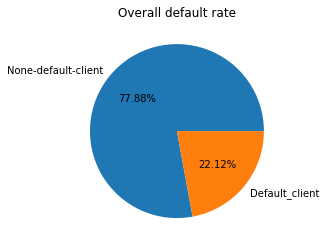

In [7]:
fig1, ax1 = plt.subplots(figsize=(4,4))
ax1.pie(pd.Series([1-data_pd_des[TARGET]['mean'], 
                   data_pd_des['default payment next month']['mean']]),
                labels=['None-default-client', 'Default_client'],autopct = '%1.2f%%');
ax1.set_title('Overall default rate');

## Data exploration

### Demographic factors distribution

In [8]:
def boxplot_variation(feature1, feature2, feature3, width=16):
    fig, ax1 = plt.subplots(ncols=1, figsize=(width,6))
    s = sns.boxplot(ax = ax1, x=feature1, y=feature2, hue=feature3,
                data=data_pd, palette="PRGn",showfliers=False)
    s.set_xticklabels(s.get_xticklabels(),rotation=90)
    plt.show();

#### Age distribution grouped by marriage status and sex

Marriage status meaning is:

 * 0 : unknown (let's consider as others as well)
 * 1 : married
 * 2 : single
 * 3 : others

Sex meaning is:

 * 1 : male
 * 2 : female

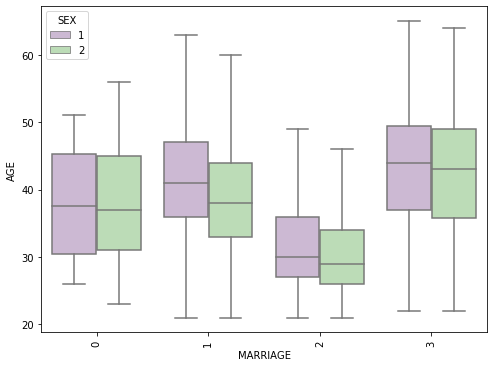

In [9]:
boxplot_variation('MARRIAGE','AGE', 'SEX',8)

**Observation:**
  * Married status 3 (others), with mean values over 40 could be mostly vidowed or divorced whilst
  * Married status 0 could be not specified 

#### Credit amount limit distribution grouped by marriage status and education level

Education status meaning is:
* 0 : 
* 1 : graduate school
* 2 : university
* 3 : high school
* 4 : others
* 5 : unknown
* 6 : unknown

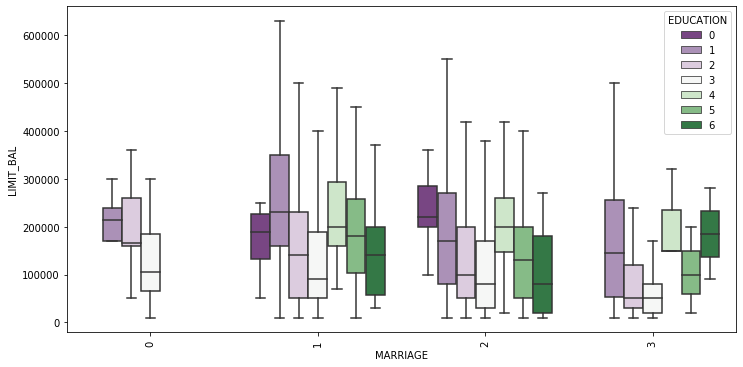

In [10]:
boxplot_variation('MARRIAGE','LIMIT_BAL', 'EDUCATION',12)

**Observation:**
  * Credit amount limit decrease as education level decrease 
  * Married status 0 has only education level of university, high scool and others

### Amount of credit limit

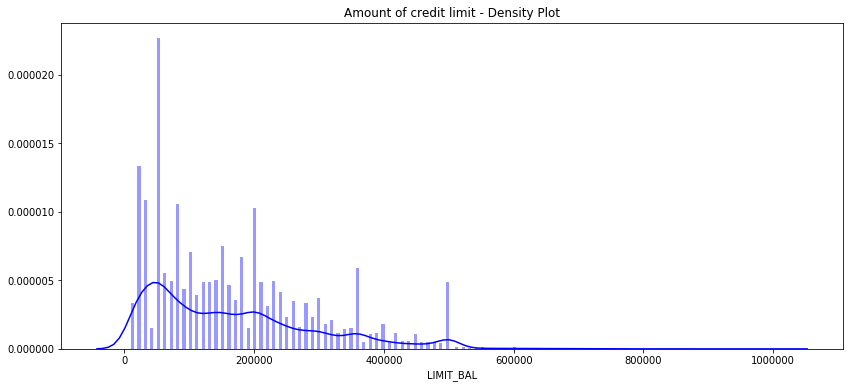

In [11]:
plt.figure(figsize = (14,6))
plt.title('Amount of credit limit - Density Plot')
sns.set_color_codes("pastel")
sns.distplot(data_pd['LIMIT_BAL'],kde=True,bins=200, color="blue")
plt.show();

Amount of credit limit grouped by target

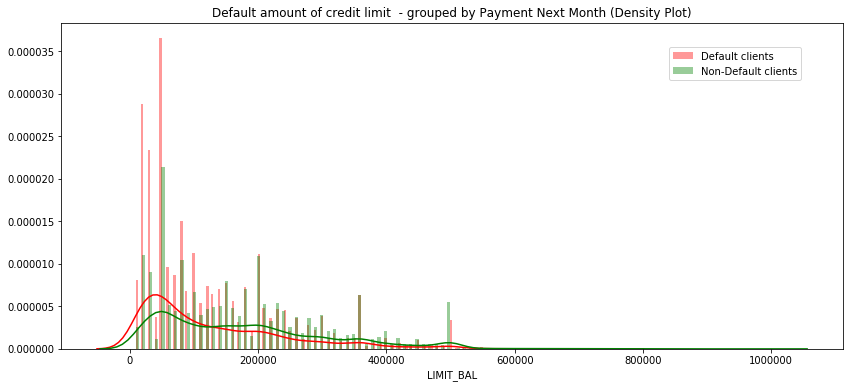

In [12]:
class_0 = data_pd.loc[data_pd[TARGET] == 0]["LIMIT_BAL"]
class_1 = data_pd.loc[data_pd[TARGET] == 1]["LIMIT_BAL"]
fig=plt.figure(figsize = (14,6))
plt.title('Default amount of credit limit  - grouped by Payment Next Month (Density Plot)')
sns.set_color_codes("pastel")
sns.distplot(class_1,kde=True,bins=200, color="red")
sns.distplot(class_0,kde=True,bins=200, color="green")
fig.legend(labels=['Default clients','Non-Default clients'],
           loc='upper right',bbox_to_anchor=(0.8, 0.8))
plt.show();

# Prepare the Data for Machine Learning Algorithms

## Train-test split 

In [13]:
train_df, test_df = train_test_split(data_pd, test_size=0.2, random_state=2019, shuffle=True )
X_train, y_train = train_df.iloc[:,1:-1], train_df.iloc[:,-1]
X_test,  y_test  = test_df.iloc[:,1:-1],  test_df.iloc[:,-1]

y_train_dist,  y_test_dist = y_train.value_counts(normalize=True), y_test.value_counts(normalize=True)

print('y_train class distribution')
print('Class 0: {:.2f},'.format(y_train_dist[0]), 'Class 1: {:.2f}'.format(y_train_dist[1]))
print('y_test class distribution')
print('Class 0: {:.2f},'.format(y_test_dist[0]), 'Class 1: {:.2f}'.format(y_test_dist[1]))

y_train class distribution
Class 0: 0.78, Class 1: 0.22
y_test class distribution
Class 0: 0.79, Class 1: 0.21


## Sampling on train dataset

In [14]:
# Undersampling
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

# sm = SMOTE(random_state = 2019)
rus = RandomUnderSampler(random_state=2019)
print('Class value counts before sampling:')
y_train.value_counts()

# X_train, y_train = sm.fit_sample(X_train, y_train)
X_train, y_train = rus.fit_resample(X_train, y_train)

print('Class value counts after sampling:')
y_train.value_counts()

Using TensorFlow backend.


Class value counts before sampling:


0    18654
1     5346
Name: default payment next month, dtype: int64

Class value counts after sampling:


1    5346
0    5346
Name: default payment next month, dtype: int64

## Feature Transformation

Weight of Evidence and information value is a common statistic used in classification models to gauge the predictive power of your feature set. Let's now do Weight of Evidence transformation.

In [15]:
def data_vars(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv)

def woe_trans(df, final_iv):
    df_woe = df.copy(deep=True)
    for column in df.columns:
        dvar = df_woe[column]
        var_woe = final_iv[final_iv['VAR_NAME']==column][['MIN_VALUE','MAX_VALUE','WOE']]
        var_woe.reset_index(drop=True, inplace=True)
        split_list = [[var_woe['MIN_VALUE'][k], var_woe['MAX_VALUE'][k]] for k in range(len(var_woe))]
        for i in range(len(var_woe)):
            dvar[(dvar>=split_list[i][0]) & (dvar <=split_list[i][1])] = var_woe['WOE'][i]
    return df_woe

# Define a binning function for continuous independent variables
def mono_bin(Y, X, n = max_bin):
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

# Define a binning function for categorical independent variables
def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)

In [16]:
# Fit on the train data
final_iv, IV = data_vars(X_train,y_train)

# Transform on train and test data
X_train = woe_trans(X_train, final_iv)
X_test = woe_trans(X_test, final_iv)
X_train.head()
X_test.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,-0.644304,-0.084770,-0.025133,-0.001515,0.016068,-0.564273,-0.379317,-0.314183,-0.265329,-0.232505,...,0.008227,-0.00823,-0.01721,-0.053885,-0.052244,-0.530628,-0.086683,-0.427486,-0.346360,-0.378600
1,0.176247,-0.084770,0.113641,-0.001515,0.016068,-0.564273,-0.379317,-0.314183,-0.265329,-0.232505,...,-0.008234,0.00823,0.01721,0.053885,-0.052244,-0.078262,-0.086683,0.031229,0.041186,0.060591
2,-0.268890,0.125221,-0.025133,-0.001515,0.016068,-0.564273,-0.379317,-0.314183,-0.265329,-0.232505,...,0.008227,-0.00823,0.01721,-0.053885,0.012295,0.070867,0.070635,0.031229,0.041186,0.307679
3,0.176247,-0.084770,-0.025133,-0.001515,-0.015374,-0.564273,-0.379317,-0.314183,-0.265329,-0.232505,...,0.008227,-0.00823,-0.01721,0.053885,0.012295,0.070867,-0.465386,-0.065118,0.041186,-0.378600
4,-0.390290,-0.084770,-0.025133,-0.001515,-0.015374,1.267257,1.510385,-0.314183,-0.265329,-0.232505,...,0.008227,-0.00823,-0.01721,-0.053885,0.597991,0.500746,-0.086683,-0.427486,-0.346360,-0.378600


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
9706,0.059378,-0.08477,0.113641,-0.001515,0.016068,1.267257,1.510385,1.389705,1.471864,1.573905,...,-0.008234,0.00823,0.01721,0.053885,-0.052244,0.070867,-0.086683,0.459685,0.041186,-0.378600
13034,0.176247,-0.08477,-0.025133,-0.001515,-0.015374,-0.564273,-0.379317,-0.314183,-0.265329,-0.232505,...,-0.008234,0.00823,0.01721,0.053885,-0.052244,-0.078262,-0.086683,-0.065118,0.041186,0.060591
23847,-0.390290,-0.08477,-0.025133,-0.001515,0.016068,-0.564273,-0.379317,-0.314183,-0.265329,-0.232505,...,0.008227,-0.00823,-0.01721,-0.053885,0.012295,0.500746,0.481204,0.031229,-0.346360,0.307679
14912,-0.644304,-0.08477,-0.025133,-0.001515,0.016068,-0.564273,-0.379317,1.389705,1.471864,-0.232505,...,0.008227,-0.00823,-0.01721,-0.053885,-0.587080,0.500746,0.070635,0.459685,0.041186,0.307679
11359,0.176247,-0.08477,-0.025133,-0.001515,0.016068,1.267257,-0.379317,-0.314183,-0.265329,-0.232505,...,-0.008234,0.00823,0.01721,0.053885,-0.052244,-0.078262,-0.086683,-0.065118,-0.346360,-0.378600


## Feature Scaling

We apply scaling on train dataset first, extract the scaling parameters, and apply it on the test dataset. 

In [17]:
mm_scaler = preprocessing.MinMaxScaler()

X_train_mm = mm_scaler.fit_transform(X_train)
X_test_mm = mm_scaler.transform(X_test)

# MinMaxScalar changed dataset type to be array, we change it back
X_train = pd.DataFrame(X_train_mm, index=X_train.index, columns=X_train.columns)
X_test  = pd.DataFrame(X_test_mm,  index=X_test.index,  columns=X_test.columns)

X_train.shape, X_test.shape

((10692, 23), (6000, 23))

# Explore many different methods

We now explore many different methods with automated hyperparameter tuning based on Bayesian optimization. 

## Logistic Regression

In [18]:
def lgt_hyper_param(C,
                    max_iter,
                    tol,
                    l1_ratio
                   ):
    
    clf = LogisticRegression(
        solver = 'saga',
        C=C,
        max_iter=int(max_iter),
        tol=tol)
    return np.mean(cross_val_score(clf, X_train, y_train, cv=K_FOLD, scoring='roc_auc'))

pbounds = {
    'C': (0.01, 10000),
    'max_iter': (10,10000),
    'tol': (1e-6, 1e-2),
    'l1_ratio':(0,1)}

optimizer = BayesianOptimization(
    f=lgt_hyper_param,
    pbounds = pbounds,
    random_state=2019
)
optimizer.maximize(
    init_points=2,
    n_iter=3
)

|   iter    |  target   |     C     | l1_ratio  | max_iter  |    tol    |
-------------------------------------------------------------------------
|  1        |  0.7604   |  9.035e+0 |  0.3931   |  6.243e+0 |  0.006379 |
|  2        |  0.7605   |  8.805e+0 |  0.2992   |  7.025e+0 |  0.009032 |
|  3        |  0.7605   |  2.383    |  0.7294   |  22.11    |  0.00349  |
|  4        |  0.7605   |  18.29    |  0.6557   |  9.973e+0 |  0.004478 |
|  5        |  0.7605   |  9.978e+0 |  0.0224   |  36.06    |  0.005628 |


Get the best parameters

In [19]:
lgt_clf = LogisticRegression(
                        solver = 'saga',
                        C  = optimizer.max['params']['C'],
                        max_iter = int(optimizer.max['params']['max_iter']),
                        tol = optimizer.max['params']['tol'],
                        l1_ratio = optimizer.max['params']['l1_ratio']
)

Fit the model

In [20]:
lgt_clf.fit(X_train, y_train)

LogisticRegression(C=2.3830045327467992, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1,
                   l1_ratio=0.7294013398825309, max_iter=22, multi_class='auto',
                   n_jobs=None, penalty='l2', random_state=None, solver='saga',
                   tol=0.0034897464446233266, verbose=0, warm_start=False)

## XGBoost

In [21]:
def xgb_hyper_param(learning_rate,
                        n_estimators,
                        max_depth,
                        subsample,
                        colsample,
                        gamma):
 
    max_depth = int(max_depth)
    n_estimators = int(n_estimators)
 
    clf = xgb.XGBClassifier(
        objective="binary:logistic",
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        max_depth=max_depth,
        gamma=gamma)
    return np.mean(cross_val_score(clf, X_train, y_train, cv=K_FOLD, scoring='roc_auc'))

pbounds = {
    'learning_rate': (0.01, 1.0),
    'n_estimators': (100, 1000),
    'max_depth': (3,10),
    'subsample': (0.8, 1.0),  # Change for big datasets
    'colsample': (0.8, 1.0),  # Change for datasets with lots of features
    'gamma': (0, 5)}

optimizer = BayesianOptimization(
    f=xgb_hyper_param,
    pbounds = pbounds,
    random_state=2019
)
optimizer.maximize(
    init_points=2,
    n_iter=3
)

|   iter    |  target   | colsample |   gamma   | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------------------------------
|  1        |  0.7288   |  0.9807   |  1.965    |  0.6277   |  7.465    |  892.4    |  0.8598   |
|  2        |  0.7579   |  0.9404   |  4.516    |  0.8826   |  5.84     |  507.2    |  0.8534   |
|  3        |  0.7294   |  0.9604   |  0.1441   |  0.1733   |  9.902    |  100.2    |  0.9285   |
|  4        |  0.7069   |  0.8888   |  0.02234  |  0.2382   |  9.957    |  437.5    |  0.8161   |
|  5        |  0.7431   |  0.8      |  0.0      |  0.01     |  10.0     |  710.9    |  0.8      |


Get the best parameters

In [22]:
xgb_clf = xgb.XGBClassifier(objective="binary:logistic",
                        learning_rate = optimizer.max['params']['learning_rate'],
                        n_estimators  = int(optimizer.max['params']['n_estimators']),
                        max_depth     = int(optimizer.max['params']['max_depth']),
                        subsample     = optimizer.max['params']['subsample'],
                        colsample     = optimizer.max['params']['colsample'],
                        gamma         = optimizer.max['params']['gamma'])

Fit the model

In [23]:
xgb_clf.fit(X_train, y_train, eval_metric='auc', verbose=False,
            eval_set=[(X_test, y_test)], early_stopping_rounds=50)

XGBClassifier(base_score=0.5, booster='gbtree', colsample=0.9404396540373103,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              gamma=4.516030806611217, learning_rate=0.8825681072168009,
              max_delta_step=0, max_depth=5, min_child_weight=1, missing=None,
              n_estimators=507, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=0.8534140647189611, verbosity=1)

Plot feature of importance

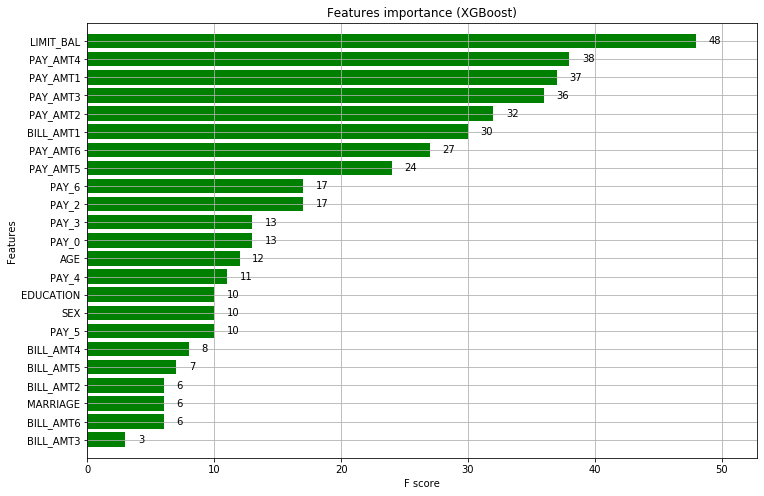

In [24]:
fig, (ax) = plt.subplots(ncols=1, figsize=(12,8))
xgb.plot_importance(xgb_clf, height=0.8, title="Features importance (XGBoost)", 
                    ax=ax, color="green") 
plt.show();

## Artificial Neural Networks

In [25]:
import tensorflow.keras.initializers
import statistics
import tensorflow.keras
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras.layers import LeakyReLU,PReLU
from tensorflow.keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.base import clone
import keras

In [26]:
# Define my cross_val_score
def ann_hyper_param(dropout, lr, neuronPct, neuronShrink):
    skfolds = StratifiedKFold(n_splits=K_FOLD, random_state=2019)
    scores = []
    for train_idx, val_idx in skfolds.split(X_train.values, y_train.values):
        clf = make_model(dropout, lr, neuronPct, neuronShrink) # make a new model each time to avoid conflit
        X_train_folds = X_train.values[train_idx]
        y_train_folds = y_train.values[train_idx]
        X_val_fold   = X_train.values[val_idx]
        y_val_fold   = y_train.values[val_idx]
        clf.fit(X_train_folds, y_train_folds, verbose=0) # add epochs?
        y_pred = clf.predict(X_val_fold)
        score = roc_auc_score(y_val_fold, y_pred)
        scores.append(score)
        keras.backend.clear_session() # clear the current model
    return statistics.mean(scores) 

def make_model(dropout, lr, neuronPct, neuronShrink):
    neuronCount = int(neuronPct * 5000)
    model = Sequential()
    layer = 0
    while neuronCount>25 and layer<10:
        if layer==0:
            model.add(Dense(neuronCount, 
                            input_dim=X_train.shape[1], 
                            kernel_initializer = 'uniform',
                            activation='relu')) 
        else:
            model.add(Dense(neuronCount, kernel_initializer = 'uniform', activation='relu')) 
        model.add(Dropout(dropout))
        neuronCount *= neuronShrink
        layer += 1
    model.add(Dense(1,kernel_initializer = 'uniform', activation='sigmoid')) # Output
#     model.summary()
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=lr), metrics=['accuracy'])
    return model

In [27]:
# Bounded region of parameter space
pbounds = {
           'dropout': (0.0, 0.499),
           'lr': (0.0, 0.1),
           'neuronPct': (0.01, 1),
           'neuronShrink': (0.01, 1)
          }
optimizer = BayesianOptimization(
    f=ann_hyper_param,
    pbounds=pbounds,
    random_state=2019
)
optimizer.maximize(init_points=2, n_iter=3)

|   iter    |  target   |  dropout  |    lr     | neuronPct | neuron... |
-------------------------------------------------------------------------
|  1        |  0.4993   |  0.4508   |  0.03931  |  0.6277   |  0.6415   |
|  2        |  0.5004   |  0.4394   |  0.02992  |  0.7052   |  0.9042   |
|  3        |  0.7545   |  0.007591 |  0.08659  |  0.01484  |  0.02936  |
|  4        |  0.5      |  0.0      |  0.1      |  0.01     |  1.0      |
|  5        |  0.6636   |  0.0      |  0.1      |  1.0      |  0.01     |


Get the best parameters

In [28]:
ann_clf = make_model(dropout = optimizer.max['params']['dropout'], 
                    lr = optimizer.max['params']['lr'],
                    neuronPct = optimizer.max['params']['neuronPct'], 
                    neuronShrink =optimizer.max['params']['neuronShrink'])
ann_clf.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 74)                1776      
_________________________________________________________________
dropout (Dropout)            (None, 74)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 75        
Total params: 1,851
Trainable params: 1,851
Non-trainable params: 0
_________________________________________________________________


In [29]:
ann_clf.fit(X_train.values, y_train.values,  
            epochs=30, verbose=True)

Train on 10692 samples
Epoch 1/30
10692/10692 [==============================] - 1s 75us/sample - loss: 0.6102 - accuracy: 0.6798
Epoch 2/30
10692/10692 [==============================] - 0s 37us/sample - loss: 0.5952 - accuracy: 0.6927
Epoch 3/30
10692/10692 [==============================] - 0s 37us/sample - loss: 0.5952 - accuracy: 0.6974
Epoch 4/30
10692/10692 [==============================] - 0s 37us/sample - loss: 0.5972 - accuracy: 0.6915s - loss: 0.5979 - accuracy: 0.68
Epoch 5/30
10692/10692 [==============================] - 0s 37us/sample - loss: 0.5948 - accuracy: 0.6923
Epoch 6/30
10692/10692 [==============================] - 0s 36us/sample - loss: 0.5948 - accuracy: 0.6933
Epoch 7/30
10692/10692 [==============================] - 0s 37us/sample - loss: 0.5957 - accuracy: 0.6945
Epoch 8/30
10692/10692 [==============================] - 0s 36us/sample - loss: 0.5955 - accuracy: 0.6971
Epoch 9/30
10692/10692 [==============================] - 0s 37us/sample - loss: 0.5946 

# Evaluate Model Performance 

We can measure the model performance on its classification accuracy and predicted probability accuracy.  

Due to the undersampling, we need to calibrate the predicted probability before using it. 
According to work from Andrea et. al. (https://www3.nd.edu/~rjohns15/content/papers/ssci2015_calibrating.pdf), we can calibrate the probility from sampled data as the following:

$ p =\dfrac{\beta  p_s }{(\beta - 1)p_s + 1}$

where $p_s$ is the predicted probability before calibration, and $\beta$ is the ration of positive and negative events.

In [30]:
def prob_calibration(prob_pred: np.array, sampling_ratio: float) -> np.array:
    prob_cali = (sampling_ratio*prob_pred) / (1+(sampling_ratio-1)*prob_pred)
    return prob_cali

## Classification accuracy

### Precision and Recall Tradeoff

The precision and recall are defined as the following: 
$$\text{precision}=\dfrac{TP}{TP+FP}, \space\space\space \text{and   } \text{recall}=\dfrac{TP}{TP+FN}$$

$TP$: number of true positives, $FP$: number of false positives, $FN$: number of false negatives. 

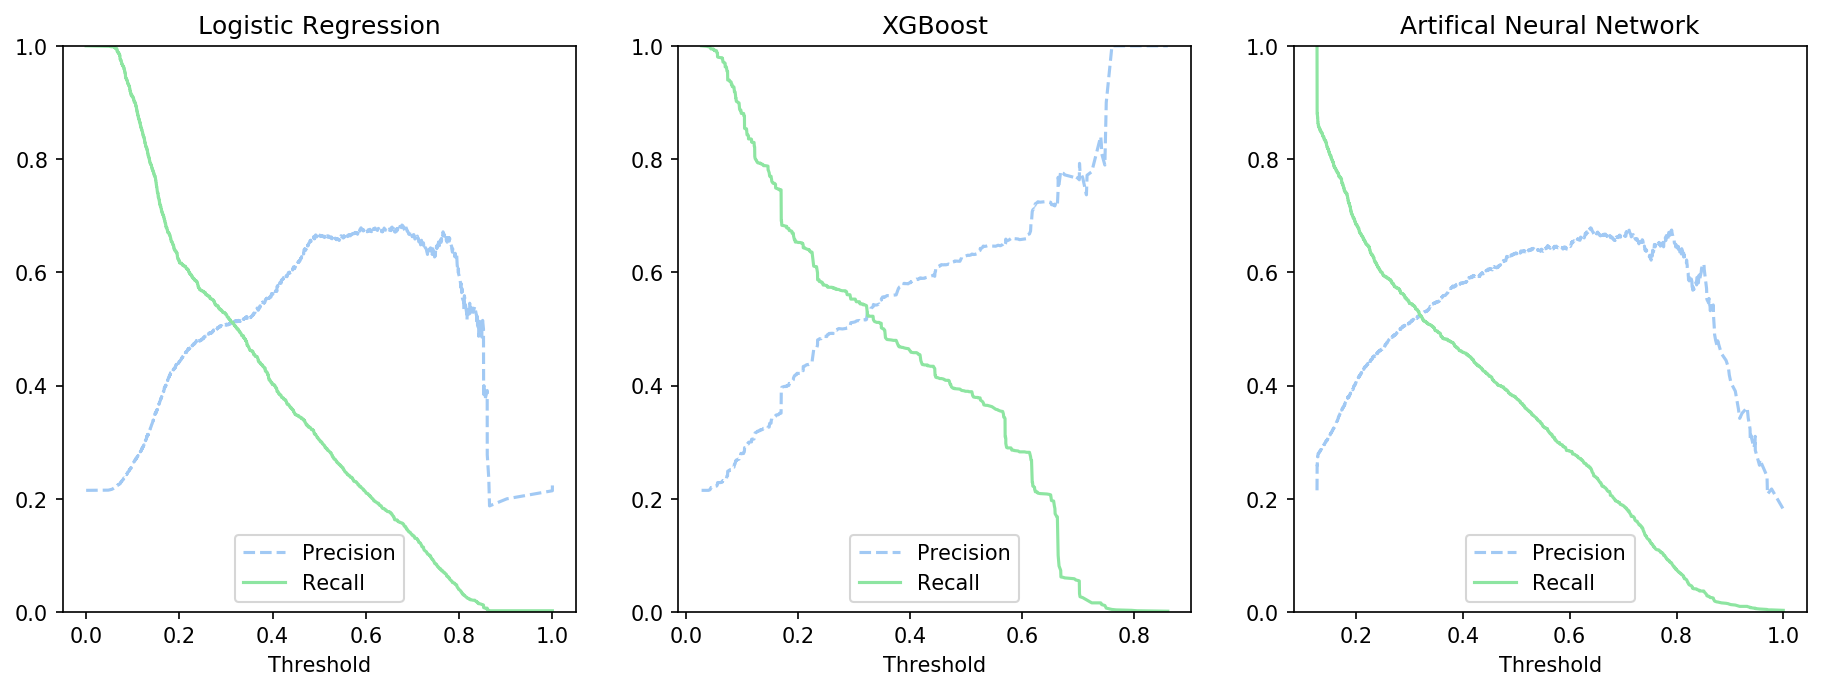

In [31]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, 'g-', linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="lower center")
    plt.ylim([0, 1])

def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=12)
    plt.ylabel("Precision", fontsize=12)
    plt.axis([0, 1, 0, 1])

y_test_pred_prob_lgt_raw = lgt_clf.predict_proba(X_test)[:,1]
y_test_pred_prob_xgb_raw = xgb_clf.predict_proba(X_test)[:,1]
y_test_pred_prob_ann_raw = ann_clf.predict_proba(X_test)[:,0]

y_test_pred_prob_lgt = prob_calibration(y_test_pred_prob_lgt_raw, y_test_dist[1]/y_test_dist[0])
y_test_pred_prob_xgb = prob_calibration(y_test_pred_prob_xgb_raw, y_test_dist[1]/y_test_dist[0])
y_test_pred_prob_ann = prob_calibration(y_test_pred_prob_ann_raw, y_test_dist[1]/y_test_dist[0])

pl, rl, tl = precision_recall_curve(y_test, y_test_pred_prob_lgt)
px, rx, tx = precision_recall_curve(y_test, y_test_pred_prob_xgb)
pn, rn, tn = precision_recall_curve(y_test, y_test_pred_prob_ann)

mpl.rcParams['figure.dpi']= 150
plt.figure(figsize=(15,5))
plt.subplot(131)
plot_precision_recall_vs_threshold(pl, rl, tl );
plt.title('Logistic Regression')
plt.subplot(132)
plot_precision_recall_vs_threshold(px, rx, tx);
plt.title('XGBoost');
plt.subplot(133)
plot_precision_recall_vs_threshold(pn, rn, tn);
plt.title('Artifical Neural Network');

In [32]:
y_test_pred_prob_xgb_raw.shape

(6000,)

### ROC -AUC

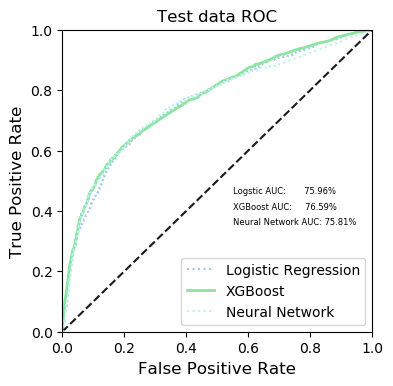

In [33]:
fp_l, tp_l, td_l = roc_curve(y_test, y_test_pred_prob_lgt)
fp_x, tp_x, td_x = roc_curve(y_test, y_test_pred_prob_xgb)
fp_n, tp_n, td_n = roc_curve(y_test, y_test_pred_prob_ann)
auc_lgt = roc_auc_score(y_test, y_test_pred_prob_lgt)
auc_xgb = roc_auc_score(y_test, y_test_pred_prob_xgb)
auc_ann = roc_auc_score(y_test, y_test_pred_prob_ann)

mpl.rcParams['figure.dpi']= 100
plt.figure(figsize=(4,4))
plt.plot(fp_l, tp_l,'b:',label='Logistic Regression')
plot_roc_curve(fp_x, tp_x,'XGBoost')
plt.plot(fp_n, tp_n,'c:',label='Neural Network')
plt.title('Test data ROC')
plt.legend(loc='lower right')
tex_lgt = 'Logstic AUC:  %10.2f%%'%(auc_lgt*100)
tex_xgb = 'XGBoost AUC: %9.2f%%'%(auc_xgb*100)
tex_ann = 'Neural Network AUC: %.2f%%'%(auc_ann*100)
plt.text(0.55, 0.45, tex_lgt, fontsize=6, va='bottom')
plt.text(0.55, 0.40, tex_xgb, fontsize=6, va='bottom');
plt.text(0.55, 0.35, tex_ann, fontsize=6, va='bottom');

## Predictive accuracy of probability of default

### Estimate real probality of default with sorting smoothing method (SSM)

In [34]:
def estimate_actual_prob(y_test_pred_prob, y_test):
    asscending_index = np.argsort(y_test_pred_prob)
    y_test_pred_prob = y_test_pred_prob[asscending_index]
    y_test_asscending = y_test.iloc[asscending_index]
    y_test_actu_prob = movingaverage (y_test_asscending)
    return y_test_pred_prob, y_test_actu_prob
def movingaverage (values: np.array, nwin: int=50)-> np.array:
    values_padded = np.pad(values, (nwin//2, nwin-1-nwin//2), mode='edge')
    weights = np.repeat(1.0, nwin)/nwin
    sma = np.convolve(values_padded, weights, 'valid')
    return sma
y_test_pred_prob_lgt, y_test_actu_prob_lgt = estimate_actual_prob(y_test_pred_prob_lgt, y_test)
y_test_pred_prob_xgb, y_test_actu_prob_xgb = estimate_actual_prob(y_test_pred_prob_xgb, y_test)
y_test_pred_prob_ann, y_test_actu_prob_ann = estimate_actual_prob(y_test_pred_prob_ann, y_test)

If you care about predicting exact future values, $R^2$ is good measurement.
The coefficient of determination $R^2$ error is defined as
$$R^2 = 1 - \frac{mse(y,x)}{mse(y,mean(y))}$$

### Scatter plot

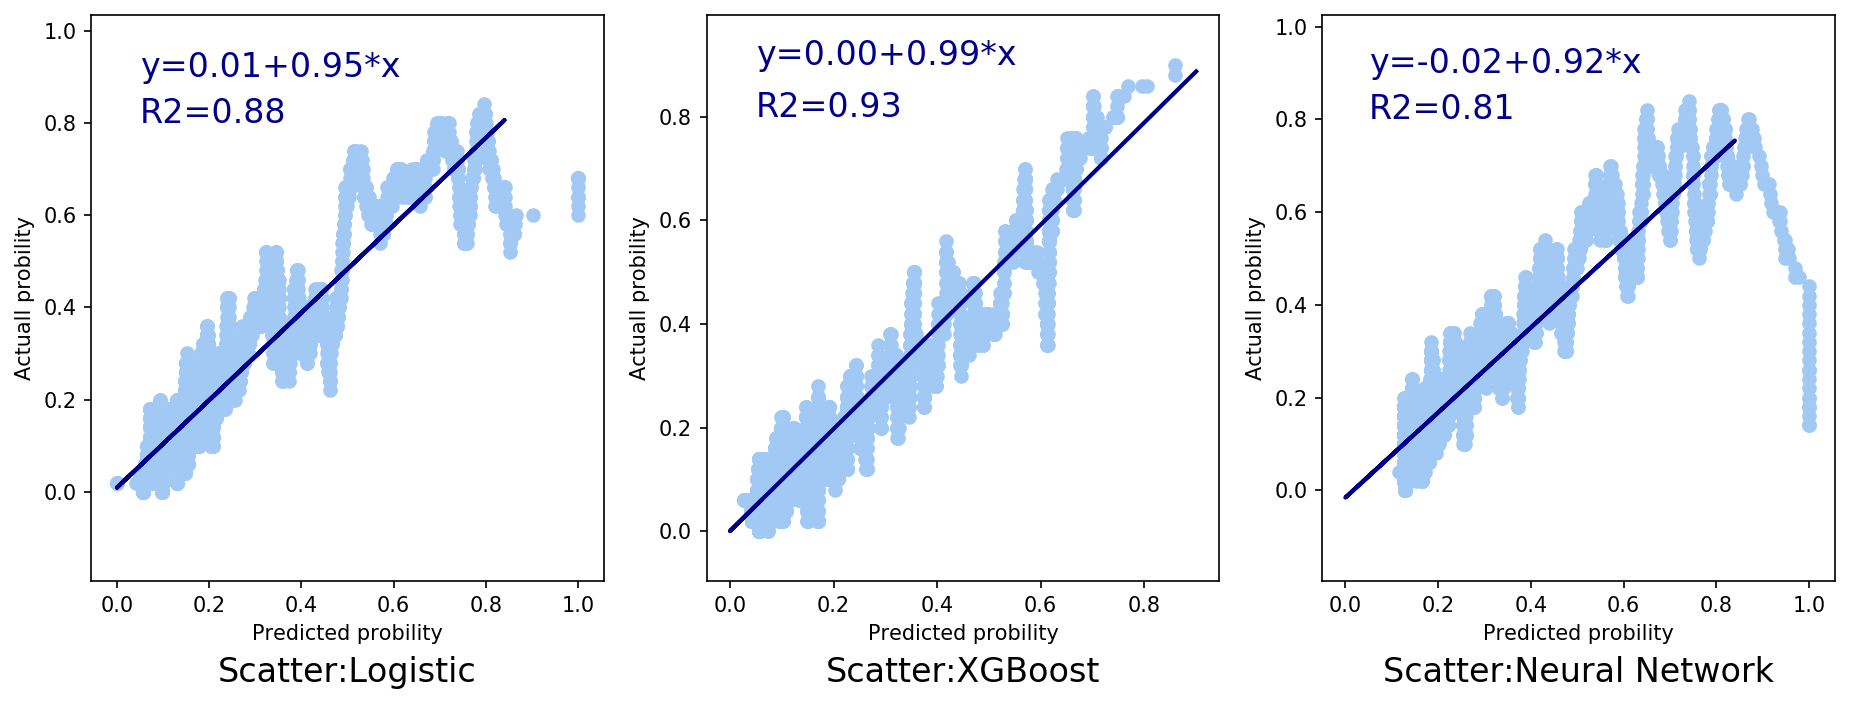

In [35]:
def plot_probility_scatter(pred_prob: np.array, actu_prob: np.array, model: str)->None:
    r2 = r2_score(actu_prob, pred_prob)
    coeff = np.polyfit(pred_prob, actu_prob,1)
    plt.plot(actu_prob,coeff[0]*actu_prob+coeff[1], 
         color='darkblue', linewidth=2)
    plt.text(0.05,0.9,'y={:.2f}+{:.2f}*x'.format(coeff[1],coeff[0]),
         color='darkblue',size=16)
    plt.text(0.05,0.8,'R2={:.2f}'.format(r2),
         color='darkblue',size=16)
    plt.scatter(pred_prob, 
                actu_prob,  
                c="b", 
                marker='o')
    plt.xlabel('Predicted probility')
    plt.ylabel('Actuall probility')
    plt.title('Scatter:' + model, fontsize=16, y=-0.2)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.axis('equal')
mpl.rcParams['figure.dpi']= 150
plt.figure(figsize=(15,5))
plt.subplot(131)
plot_probility_scatter(y_test_pred_prob_lgt, y_test_actu_prob_lgt, 'Logistic');
plt.subplot(132)
plot_probility_scatter(y_test_pred_prob_xgb, y_test_actu_prob_xgb, 'XGBoost');
plt.subplot(133)
plot_probility_scatter(y_test_pred_prob_ann, y_test_actu_prob_ann, 'Neural Network');

## Conclusion

Looks like XGBoost peformance better in terms of classification accuracy and predictive probability accuracy. But we need to spend more time and resource to train neural network to make it better. 